In [2]:
import seisbench.models as sbm
from obspy.signal.filter import bandpass
from obspy.core.utcdatetime import UTCDateTime
from tqdm import tqdm
import h5py
import torch
from scipy.signal import spectrogram, butter, sosfilt, decimate, detrend
from scipy.signal.windows import hann
import scipy
import numpy as np
import glob
import matplotlib. pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import datetime as datetime
import pickle
import collections
import multiprocessing
import types
import copy
import struct
import time
from ELEP.elep.ensemble_coherence import ensemble_semblance
from ELEP.elep.ensemble_statistics import ensemble_statistics
from ELEP.elep.trigger_func import picks_summary_simple
from ELEP.elep.ensemble_learners import ensemble_regressor_cnn
import ELEP.elep

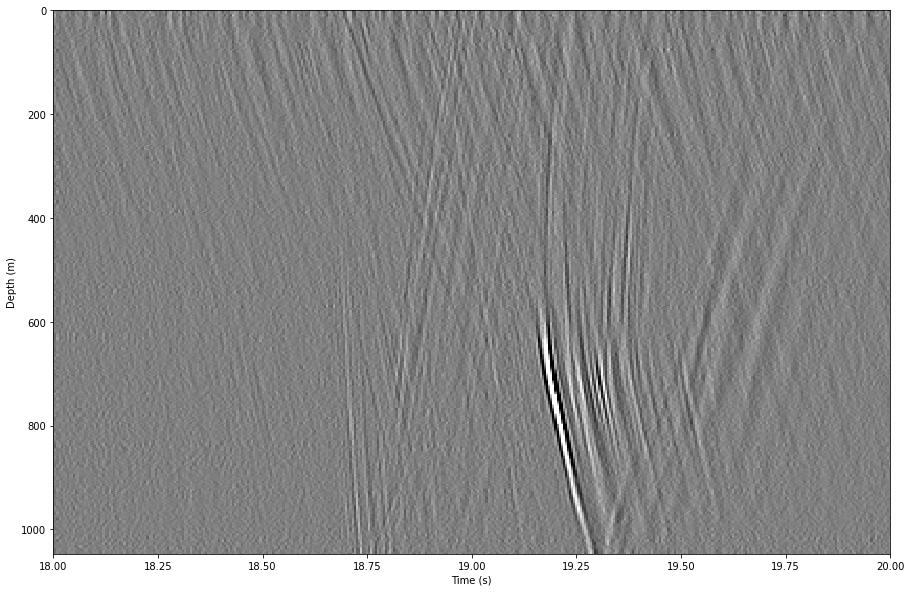

In [3]:
'''

Get some data with known events to test phase picking

'''

# read file of data containing event
path = "/store_ssd4/greenland/data/"
fname = "chans331-1360_fs200_2019-07-08T05:42:22-2019-07-08T05:42:51.h5"
file = h5py.File(path+fname)
data = file['data'][()]
file.close()

# plot the event
channels = range(331,1361)
spacing = 1.017
fig, ax = plt.subplots(figsize=(15,10))
ax.pcolormesh(np.arange(0,30,1/200),(np.array(channels)-channels[0])*spacing,np.transpose(data),cmap='gray',vmin=-50,vmax=50)
plt.gca().invert_yaxis()
ax.set_ylabel("Depth (m)")
ax.set_xlabel("Time (s)")
ax.set_xlim(18,20)
plt.show()

In [4]:
'''

Set parameters and prepare to apply model

'''

# set channels
# remember that i,ndex 0 = channel 331
start_chan = 331
channels = [1351,1361]

# no slicing because the files are natively 6000 samples
win_len = 6000     # length of time window (MUST BE 6000 SAMPLES)
step_len = 6000    # step length
blnd = [50, 50]      # number of samples to throw away from either side at the end (?)
ns = data.shape[0]
num_win = int(np.ceil((ns - win_len) / step_len)) + 1
num_chan = channels[1]-channels[0]

# choose the model(s) to run
model = "original"

# choose a gpu
device = torch.device("cuda")

# make output container
predictions = np.zeros([2, num_chan, win_len], dtype = np.float32) 

In [8]:
'''

Choose one channel of data and slice

'''

# put the data into a nwindow x ncomponent x nsample container
sliced_data = np.zeros((num_chan,3,int(ns/num_win)),dtype=np.float32)
sliced_data[:,1,:] = np.transpose(data[:,channels[0]-start_chan:channels[1]-start_chan])

# normalize by standard deviation
std_devs = np.expand_dims(np.std(sliced_data,axis=2),axis=2)
data_std_norm = np.divide(sliced_data,std_devs)
data_std_norm[np.isnan(data_std_norm)] = 0
max_vals = np.expand_dims(np.max(np.abs(sliced_data),axis=2),axis=2)
data_max_norm = np.divide(sliced_data,max_vals)
data_max_norm[np.isnan(data_std_norm)] = 0

# # cosine taper the normalized data
# taper = 0.5 * (1 + np.cos(np.linspace(np.pi, 2 * np.pi, 6)))
# data_std_norm[:,:,:6] *= tap; 
# data_std_norm[:,:,-6:] *= tap[::-1];
# data_max_norm[:,:,:6] *= tap;
# data_max_norm[:,:,-6:] *= tap[::-1];

# apply the model
eqt = sbm.EQTransformer.from_pretrained(model)
eqt.to(device);
eqt._annotate_args['overlap'] = ('Overlap between prediction windows in samples \
                                (only for window prediction models)', step_len)
eqt._annotate_args['blinding'] = ('Number of prediction samples to discard on \
                                 each side of each window prediction', (blnd[0], blnd[1]))
eqt.eval();

if model == 'original':
    data_std_torch = torch.Tensor(data_std_norm)
    torch_predictions = eqt(data_std_torch.to(device))
    
predictions[0, :] = torch_predictions[1].detach().cpu().numpy()
predictions[1, :] = torch_predictions[2].detach().cpu().numpy()

/tmp/ipykernel_1305716/2533696028.py:13: RuntimeWarning: invalid value encountered in true_divide
  data_std_norm = np.divide(sliced_data,std_devs)
/tmp/ipykernel_1305716/2533696028.py:16: RuntimeWarning: invalid value encountered in true_divide
  data_max_norm = np.divide(sliced_data,max_vals)
